# MOSAIKS Featurization Demonstration

> **IMPORTANT:** If you wish to run this code, you should select the **GPU** runtime by going to `Runtime` -> `Change runtime type` and select `GPU`. While not strictly required, it greatly improves processing speed!

> **Note**: If you wish to save this notebook with any of your changes, please make sure to click on `File` -> `Save a copy in Drive`. All changes will be lost if you close this tab without saving a copy in your Google Drive. All changes made before saving a copy in Drive will be saved in the notebook after you save a copy in Drive. Data is downloaded from the internet and stored in the temporary disk of the environment. This data will be deleted once the session is over.

This demonstration will show you a few key concepts about turning satellite data into MOSAIKS features. The notebook will guide you through the featurization process, including:

1. Downloading bulk satellite imagery

1. Define a PyTorch Dataset

1. Define a PyTorch DataLoader

1. Build a random convolutional feature extractor model

1. Featurize the imagery

1. Save the features to disk

This notebook will not cover the task modeling process. Task modeling will be covered in later chapters of the training manual and in demonstration notebooks dedicated to it.

## Environment setup

### Install required packages

Google Colab is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. It comes preinstalled with many packages, including most of the ones we need for this notebook. There are a few additional packages we need to install, which we will do in the next cell.

## Setup

Install rasterio for satellite image processing, then loaad the libraries neccessary image processing.

In [4]:
%pip install rasterio
%pip install torchgeo

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [255]:
import os
import time
import torch
import shutil
import rasterio
import numpy as np
import pandas as pd

import torch.nn as nn
import requests
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

from scipy.signal import convolve2d

# from google.colab import drive

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from typing import Dict, List, Tuple, Union, Callable, Any, Optional

## Basic RCF extractor model

Before we get started and processing images, lets try to understand a basic random convolutional feature (RCF) extractor model. 

First we define the pytorch model that we will use to extract the features and a helper method. The MOSAIKS methodology describes several ways to do this and we will demonstrate the simplest method first. In the simplest method, we will generate weights for the model by drawing random samples from a normal distribution with mean 0 and standard deviation 1.

In [256]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F


class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""

    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3, bias=-1.0):
        super(RCF, self).__init__()

        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0

        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )

        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.constant_(self.conv1.bias, bias)

    def forward(self, x):
        # Two for one activation
        x1a = F.relu(self.conv1(x), inplace=True)
        x1b = F.relu(-self.conv1(x), inplace=True)

        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()

        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

### Understanding the code

The `RCF` model is a simple PyTorch neural network designed to extract RCF's from imagery data. Here’s an overview of its components and behavior:

1. Initialization:

  - Input Parameters:

    - `num_features`: Total number of output features, which must be an even number.
    - `kernel_size`: The size of the convolutional kernel.
    - `num_input_channels`: The number of channels in the input image.
    - `bias`: A bias term to be added to the convolutional output.

  - Layer Setup:

    - A single convolutional layer (`conv1`) is created. This layer takes the input image (with num_input_channels) and produces num_features/2 output channels. 
    - The kernel parameters include a `stride` of 1, no `padding`, a `dilation` of 1, and a `bias` term.

  - Weight Initialization:

    - The weights of the convolutional layer are initialized using a normal distribution with a mean of 0.0 and a standard deviation of 1.0.
    - The `bias` is initialized to a constant value of -1.0.

2. Forward Pass:

  - The input image is processed twice through the same convolutional layer:

    - First, the convolution output is passed through a ReLU activation to get `x1a`.
    - Second, the negative of the convolution output is passed through a ReLU activation to get `x1b`. 
    - This effectively captures features that might be suppressed in a standard ReLU pass.

  - Both `x1a` and `x1b` are then globally averaged pooled using adaptive average pooling

    - This reduces each feature map to a single value (regardless of the original spatial dimensions). 
    - This operation results in tensor shapes that are either 1D (for a single image) or 2D (for a batch of images).

  - Finally, the two results (`x1a` and `x1b`) are concatenated:

    - For a single input image (resulting in 1D tensors), they are concatenated along the 0th dimension.
    - For a batch of images (resulting in 2D tensors), they are concatenated along the feature dimension (1st dimension).

3. Overall Behavior:

  - The model is lightweight and applies a single random convolution (with randomized weights and biases) to extract dual features from the input data (both positive and negative feature responses).

  - The use of adaptive average pooling ensures that the output is invariant to the input size, making it particularly flexible when handling imagery of varying spatial dimensions.

## Add empirical sampling

The next step is to add in empirical sampling. This is a more advanced method of generating weights for the model where we sample patches from the input data and use them as weights for the model. 

In [257]:
### TODO: Fix forward pass/return ###
class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features=6,  # Number of features to compute (must be divisible by 2)
        kernel_size=3,
        num_input_channels=3,
        patch_sampling=True,  # Enable empirical patch sampling
        seed=42,  # Seed for reproducibility
    ):
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.patch_sampling = patch_sampling
        self.seed = seed

        if patch_sampling:
            # We register the weight and bias tensors as "buffers". This does two things:
            # makes them behave correctly when we call .to(...) on the module, and makes
            # them explicitly _not_ Parameters of the model (which might get updated) if
            # a user tries to train with this model.
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - 2
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor):
        """Extracts patches for empirical sampling."""
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        for i in range(self.num_features // 2):
            y = np.random.randint(0, h - self.kernel_size)
            x = np.random.randint(0, w - self.kernel_size)
            patch = img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
            self.weights[i] = patch

    def forward(self, x):
        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x, self.weights, bias=self.biases, stride=1, padding=0
            )
        else:
            conv_output = self.conv1(x)

        # Activation
        x1a = F.relu(conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        return x1a, conv_output, x1a_pooled

## Activation map example

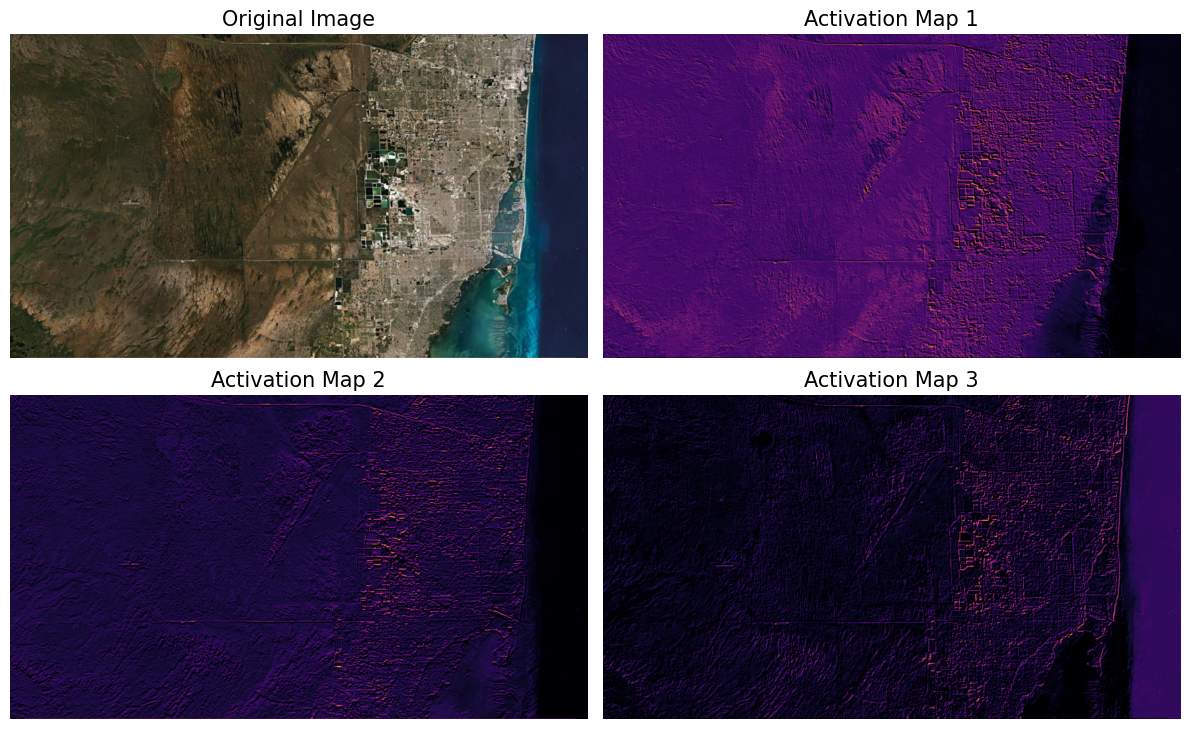

In [406]:
seed = 452

url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)

#### Find an image URL to test here ####
# url =

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

# Convert the image to a tensor
transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(num_features=6, patch_sampling=True, seed=seed)

# Pass the image through the model
act_pos, conv_map, feats, _ = model(img_tensor)


# Plot results in a 2x2 layout
fig, axs = plt.subplots(2, 2, figsize=(12, 7.5))

# Original image
axs[0, 0].imshow(img)
axs[0, 0].set_title("Original Image", fontsize=15)
axs[0, 0].axis("off")

# Positive activation maps
color_maps = ["gray", "viridis", "inferno"]
vmin = act_pos.min()
vmax = act_pos.max()
for i in range(3):
    act_pos_vis = act_pos[0, i].detach().cpu().numpy()
    axs[(i + 1) // 2, (i + 1) % 2].imshow(act_pos_vis, cmap=color_maps[2])#, vmin=vmin, vmax=vmax)
    axs[(i + 1) // 2, (i + 1) % 2].set_title(f"Activation Map {i + 1}", fontsize=15)
    axs[(i + 1) // 2, (i + 1) % 2].axis("off")

plt.tight_layout()
plot_filename = "../../images/RCF_patch_sampling_activation_maps.png"
plt.savefig(plot_filename, dpi=300)
plt.show()


In [339]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


class RCFWithPatchSampling(nn.Module):
    """
    A model for extracting Random Convolution Features (RCF) with patch sampling
    from the input image for empirical convolution kernels.
    """

    def __init__(
        self,
        num_features: int = 6,  # Number of features to compute (must be divisible by 2)
        kernel_size: int = 3,
        num_input_channels: int = 3,
        patch_sampling: bool = True,  # Enable empirical patch sampling
        seed: int = 42,  # Seed for reproducibility
        bias: float = -1.0,  # Bias value for the convolution layer
    ) -> None:
        super(RCFWithPatchSampling, self).__init__()
        # Set the seed for reproducibility
        torch.manual_seed(seed)

        assert num_features % 2 == 0, "num_features must be divisible by 2"
        self.num_features = num_features
        self.kernel_size = kernel_size
        self.num_input_channels = num_input_channels
        self.patch_sampling = patch_sampling
        self.seed = seed
        self.bias = bias

        # Will store coordinates (y, x) for each patch so that we can plot them later
        self.patch_coords = []
        self.unnormalized_patches = None

        if patch_sampling:
            # We register the weight and bias tensors as "buffers". This does two things:
            # makes them behave correctly when we call .to(...) on the module, and makes
            # them explicitly _not_ Parameters of the model (which might get updated) if
            # a user tries to train with this model.
            self.register_buffer(
                "weights",
                torch.zeros(
                    num_features // 2,
                    num_input_channels,
                    kernel_size,
                    kernel_size,
                    requires_grad=False,
                ),
            )
            self.register_buffer(
                "biases", torch.zeros(num_features // 2, requires_grad=False) - bias
            )
        else:
            self.conv1 = nn.Conv2d(
                num_input_channels,
                num_features // 2,
                kernel_size=kernel_size,
                stride=1,
                padding=kernel_size // 2,  # Ensure input shape is preserved
                bias=True,
            )
            nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
            nn.init.constant_(self.conv1.bias, -1.0)

    def extract_patches(self, img_tensor: torch.Tensor) -> None:
        """
        Extract patches for empirical sampling and store their locations.

        Parameters
        ----------
        img_tensor : torch.Tensor
            The input tensor with shape [B, C, H, W]. Note: We use only the first image.
        """
        _, c, h, w = img_tensor.shape
        np.random.seed(self.seed)
        patches = np.zeros(
            (
                self.num_features // 2,
                self.num_input_channels,
                self.kernel_size,
                self.kernel_size,
            ),
            dtype=np.float32,
        )
        self.patch_coords = []  # Reset coordinates on every call

        for i in range(self.num_features // 2):
            # Ensure that the sampled patch fully fits in the image dimensions.
            y = np.random.randint(0, h - self.kernel_size + 1)
            x = np.random.randint(0, w - self.kernel_size + 1)
            self.patch_coords.append((y, x))

            # Convert the patch to NumPy float32 explicitly
            patch = (
                img_tensor[0, :, y : y + self.kernel_size, x : x + self.kernel_size]
                .detach()
                .cpu()
                .numpy()
                .astype(np.float32)
            )
            patches[i] = patch

        # Keep a copy of the unnormalized patches
        unnorm_patches = np.copy(patches)

        # Normalize them
        patches = self._normalize(patches)

        # Convert both unnormalized and normalized patches to torch Tensors
        self.unnormalized_patches = torch.tensor(unnorm_patches)
        self.weights = torch.tensor(patches)

    def _normalize(
        self,
        patches: 'np.typing.NDArray[np.float32]',
        min_divisor: float = 1e-8,
        zca_bias: float = 0.001,
    ) -> 'np.typing.NDArray[np.float32]':

        n_patches = patches.shape[0]
        orig_shape = patches.shape
        patches = patches.reshape(n_patches, -1)

        # Zero-mean
        patches = patches - np.mean(patches, axis=1, keepdims=True)

        # Normalize
        patch_norms = np.linalg.norm(patches, axis=1)
        patch_norms[np.where(patch_norms < min_divisor)] = 1
        patches = patches / patch_norms[:, np.newaxis]

        # ZCA
        patches_cov_mat = (1.0 / n_patches) * patches.T.dot(patches)
        E, V = np.linalg.eig(patches_cov_mat)
        E += zca_bias
        sqrt_zca_eigs = np.sqrt(E)
        inv_sqrt_zca_eigs = np.diag(np.power(sqrt_zca_eigs, -1))
        global_zca = V.dot(inv_sqrt_zca_eigs).dot(V.T)

        patches_normalized = patches.dot(global_zca).dot(global_zca.T)

        # Return in original shape but let PyTorch do the float32 conversion
        return patches_normalized.reshape(orig_shape)
    
    def forward(self, x: torch.Tensor):

        if self.patch_sampling:
            self.extract_patches(x)
            conv_output = F.conv2d(
                x,
                self.weights,
                bias=self.biases,
                stride=1,
                padding=0,
            )
        else:
            conv_output = self.conv1(x)

        # Activation
        x1a = F.relu(conv_output, inplace=True)

        # Global average pooling
        x1a_pooled = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()

        # Return unnormalized patches in addition to the other outputs if patch_sampling
        if self.patch_sampling:
            return x1a, conv_output, x1a_pooled, self.unnormalized_patches
        else:
            return x1a, conv_output, x1a_pooled, None


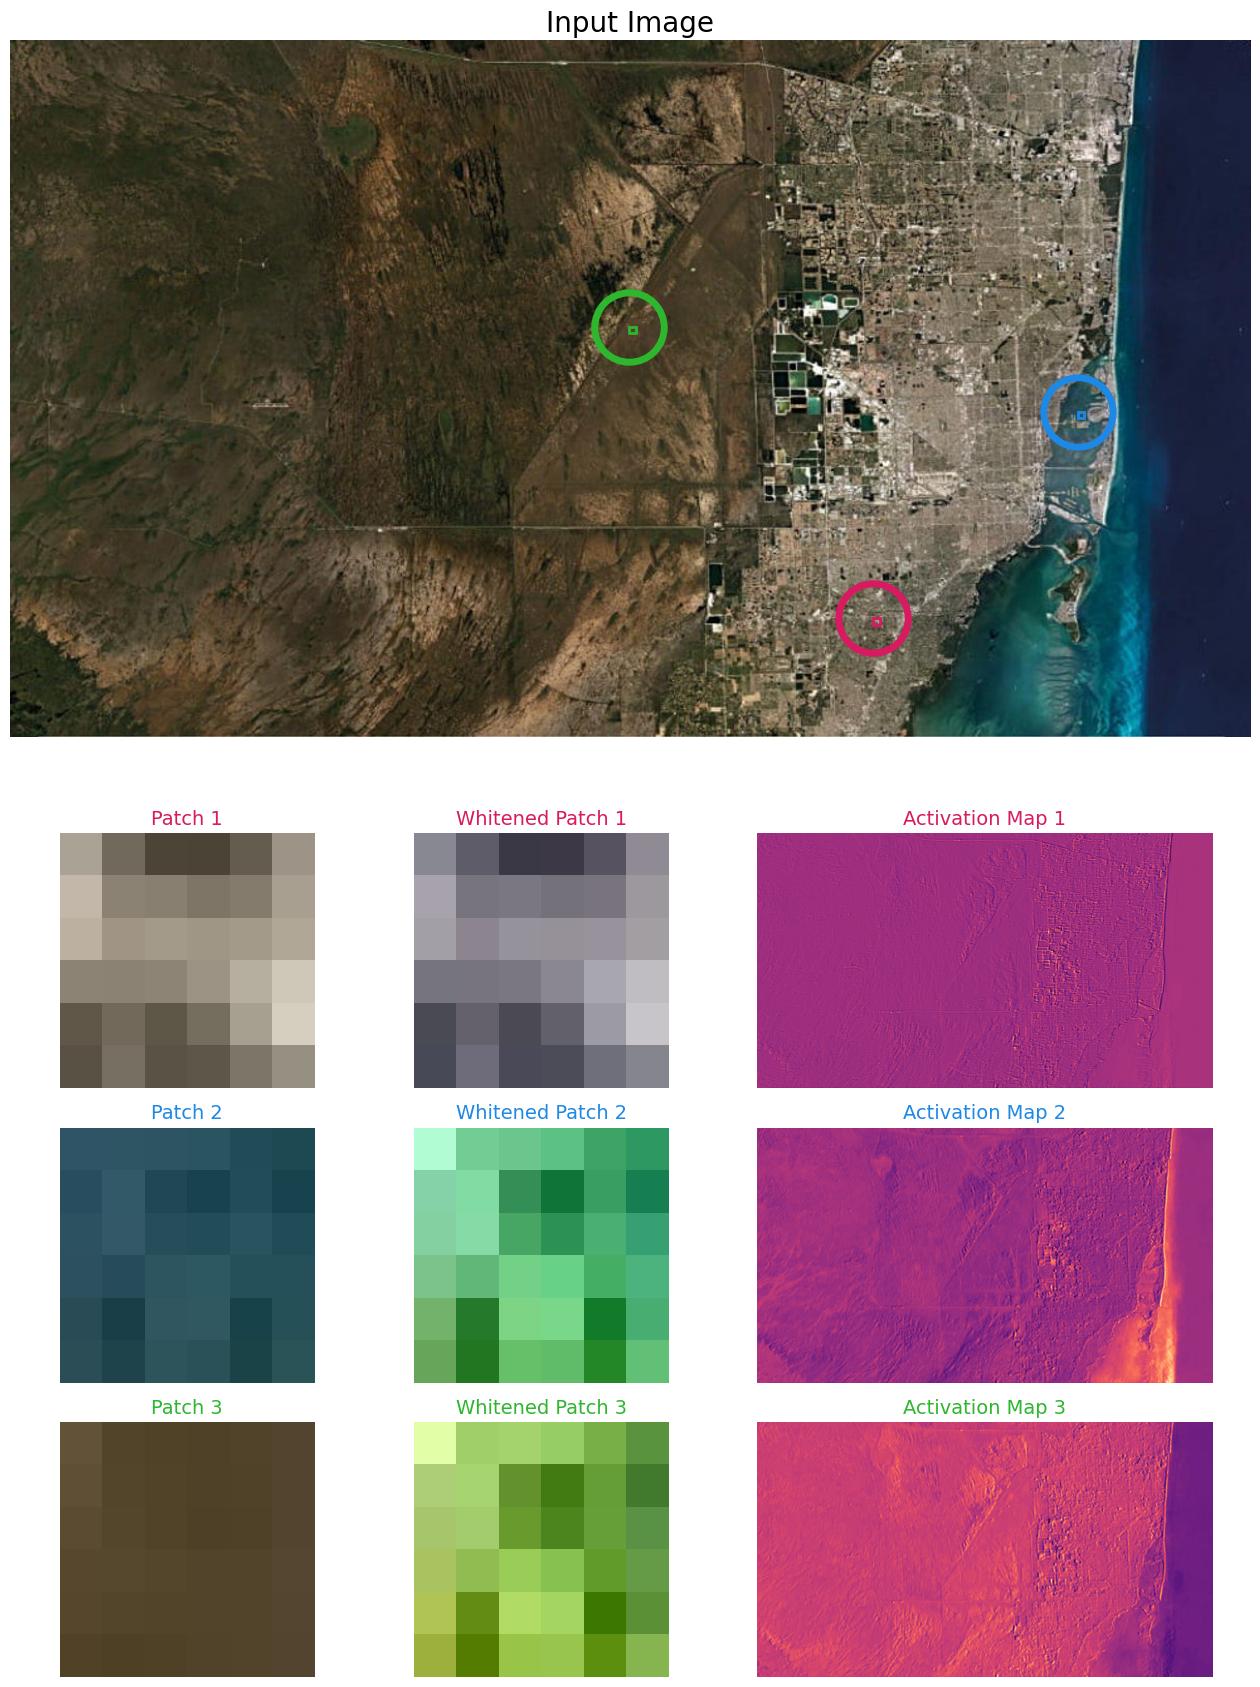

In [408]:
seed = 0
url = (
    "https://cdn.sanity.io/images/hvd5n54p/production/"
    "a332510258992b73c57a72177a391a331c91c951-945x531.jpg?"
    "w=1200&auto=format"
)

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("RGB")

transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0)

# Initialize the model
model = RCFWithPatchSampling(
    num_features=6, patch_sampling=True, seed=seed, kernel_size=6, bias=-10.0
)

# Pass the image through the model
act_pos, conv_map, feats, un_norm_patches = model(img_tensor)

patch_array = un_norm_patches.cpu().numpy()
patch_coords = model.patch_coords

norm_patch_array = model.weights.cpu().numpy()

min_val = norm_patch_array.min()
max_val = norm_patch_array.max()
# Avoid division by zero if the array is constant
if max_val - min_val < 1e-12:
    norm_patch_array = np.zeros_like(norm_patch_array)
else:
    norm_patch_array = (norm_patch_array - min_val) / (max_val - min_val)

act_maps = act_pos[0, :3].detach().cpu().numpy()
colors = ["#D81B60", "#1E88E5", "#2EB62F"]

###############################################################################
# Create a figure with 4 rows and 3 columns.
# Row 1: Original image
# Row 2: Patch 1, Whitened Patch 1, Activation Map 1
# Row 3: Patch 2, Whitened Patch 2, Activation Map 2
# Row 4: Patch 3, Whitened Patch 3, Activation Map 3
###############################################################################
fig = plt.figure(figsize=(16, 22))
gs = gridspec.GridSpec(4, 3, height_ratios=[3.5, 1.1, 1.1, 1.1], hspace=0.1, wspace=0.0, width_ratios=[1, 1, 1.5])

###############################################################################
# Row 1: Original Image (spanning all 3 columns)
###############################################################################
ax0 = fig.add_subplot(gs[0, :])
ax0.imshow(img)
ax0.set_title("Input Image", fontsize=20)
ax0.axis("off")

# Annotate with rectangles where patches are taken
for color, (y, x) in zip(colors, patch_coords):
    rect = mpatches.Rectangle(
        (x, y),
        model.kernel_size,
        model.kernel_size,
        linewidth=2,
        edgecolor=color,
        facecolor="none",
    )
    ax0.add_patch(rect)
    ax0.plot(
        x,
        y,
        marker="o",
        color=color,
        markersize=50,
        markerfacecolor="None",
        markeredgewidth=5,
    )

###############################################################################
# Rows 2-4: Each row has (Patch i, Whitened Patch i, Activation Map i)
###############################################################################
for i in range(3):
    # Patch
    ax_patch = fig.add_subplot(gs[i+1, 0])
    patch_img = patch_array[i].transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
    ax_patch.imshow(patch_img, interpolation="nearest")
    ax_patch.set_title(f"Patch {i+1}",
                       fontsize=14, color=colors[i])
    ax_patch.axis("off")

    # Whitened Patch
    ax_patch_norm = fig.add_subplot(gs[i+1, 1])
    patch_img_norm = norm_patch_array[i].transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
    ax_patch_norm.imshow(patch_img_norm, interpolation="nearest")
    ax_patch_norm.set_title(f"Whitened Patch {i+1}",
                            fontsize=14, color=colors[i])
    ax_patch_norm.axis("off")

    # Activation Map
    ax_act = fig.add_subplot(gs[i+1, 2])
    ax_act.imshow(act_maps[i], cmap="magma")
    ax_act.set_title(f"Activation Map {i+1}", fontsize=14, color=colors[i])
    ax_act.axis("off")

plt.show()


In [446]:
seed = 457
image_dir = "basemaps/planet_medres_normalized_analytic_2024-12_mosaic/clipped_images"
image_list = os.listdir(image_dir)

# image = str(np.random.choice(image_list))
image = "lon_1.255__lat_8.955.tif"

image_path = os.path.join(image_dir, image)

with rasterio.open(image_path) as src:
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))
    float_rgb = rgb.astype(np.float32)
    rgb_sharpened = sharpen_image(float_rgb)

transform = transforms.ToTensor()
img_tensor = transform(float_rgb).unsqueeze(0)

model = RCFWithPatchSampling(
    num_features=6, patch_sampling=True, seed=seed, kernel_size=4, bias=-1.0
)

# Pass the image through the model
act_pos, conv_map, feats, un_norm_patches = model(img_tensor)

patch_array = un_norm_patches.cpu().numpy()
patch_coords = model.patch_coords

norm_patch_array = model.weights.cpu().numpy()

min_val = norm_patch_array.min()
max_val = norm_patch_array.max()

# Avoid division by zero if the array is constant
if max_val - min_val < 1e-12:
    norm_patch_array = np.zeros_like(norm_patch_array)
else:
    norm_patch_array = (norm_patch_array - min_val) / (max_val - min_val)

act_maps = act_pos[0, :3].detach().cpu().numpy()
colors = ["#2EB62F", "#1E88E5", "#D81B60"]


In [160]:
seed = 4562

np.random.seed(seed)


def sharpen_image(image: np.ndarray) -> np.ndarray:
    # Define sharpening kernel
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    # Apply kernel to each band if the image has more than 2 dimensions.
    if len(image.shape) == 3:
        sharpened = np.zeros_like(image)
        for i in range(image.shape[2]):
            sharpened[:, :, i] = convolve2d(
                image[:, :, i], kernel, mode="same", boundary="symm"
            )
    else:
        sharpened = convolve2d(image, kernel, mode="same", boundary="symm")

    return np.clip(sharpened, 0, 1)

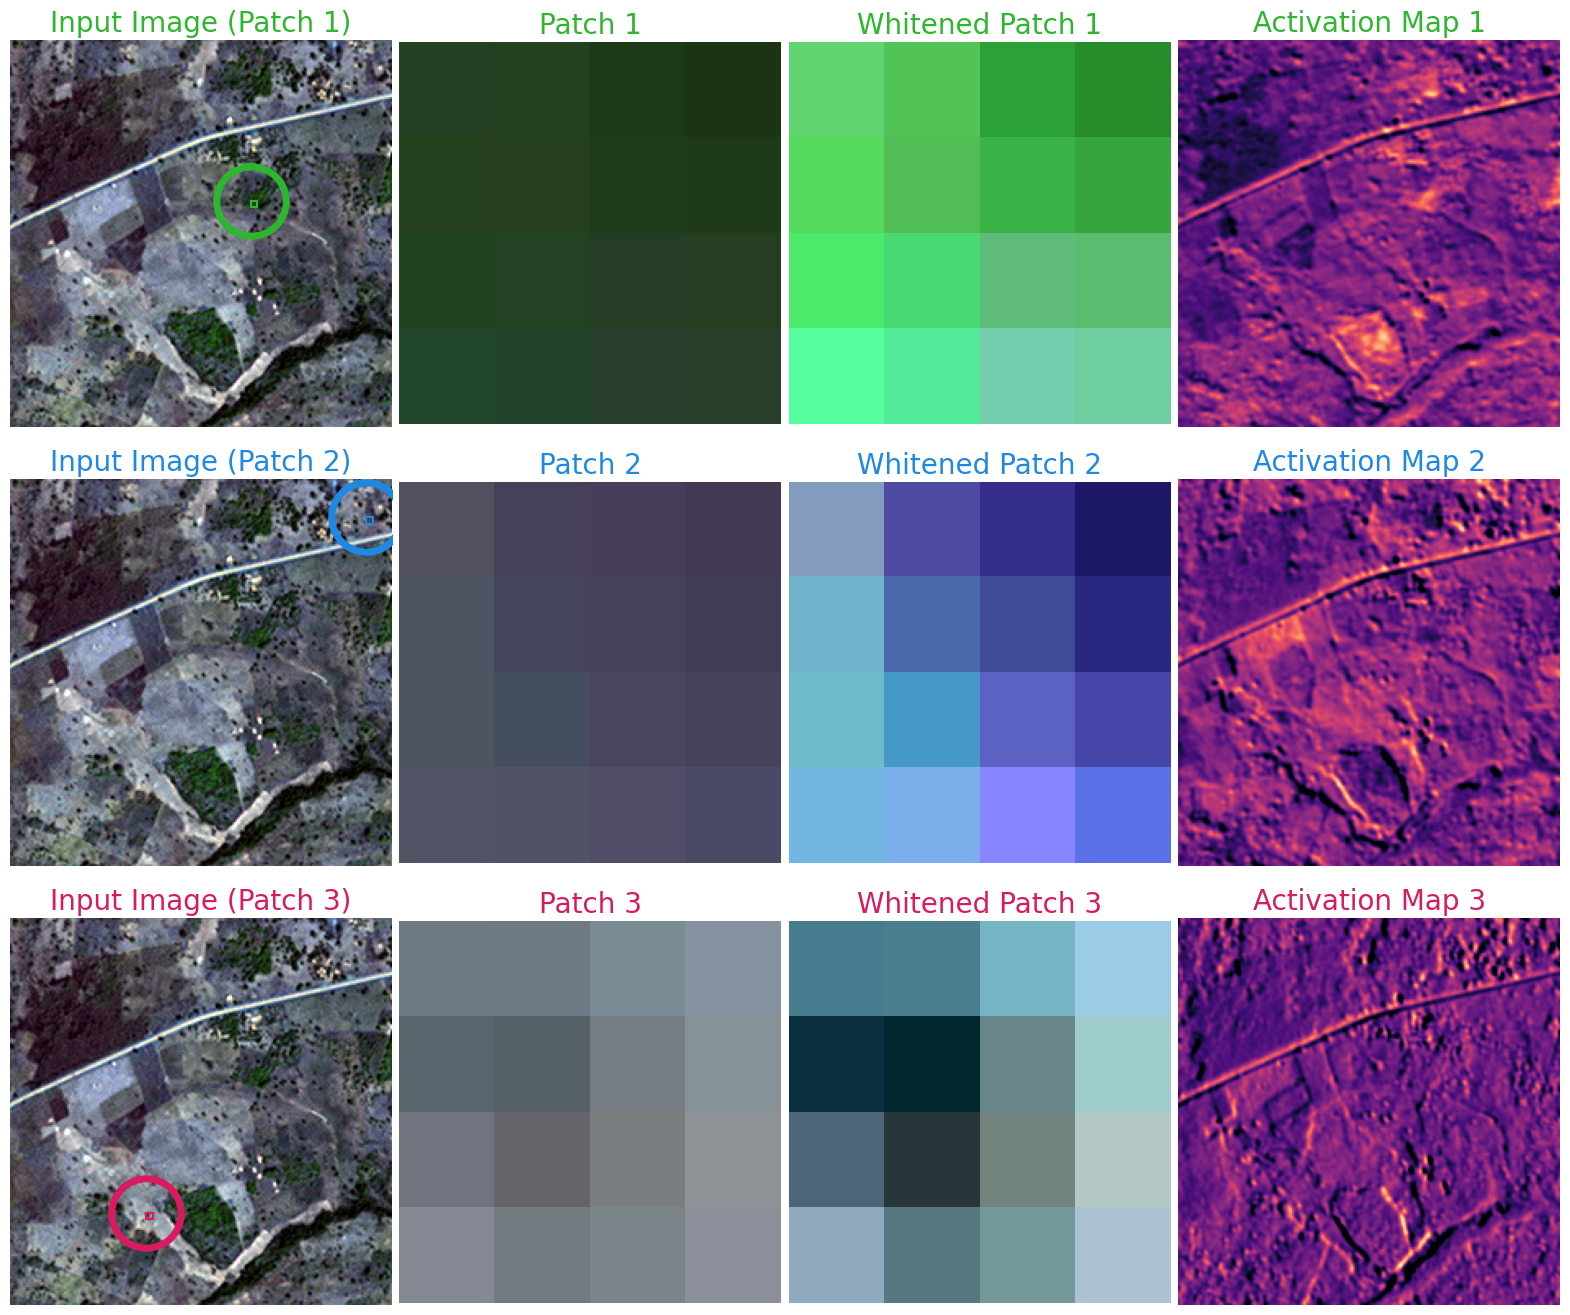

In [ ]:

fig = plt.figure(figsize=(20, 17))
gs = gridspec.GridSpec(
    3, 4,  # 3 rows (one for each patch), 4 columns
    wspace=0.02,
    hspace=0.02,
)

for i in range(3):
    # (a) Input image with only patch i highlighted (column 0)
    ax_img = fig.add_subplot(gs[i, 0])
    ax_img.imshow(rgb_sharpened)
    ax_img.axis("off")
    ax_img.set_title(f"Input Image (Patch {i+1})", fontsize=20, color=colors[i])
    
    # Highlight only this patch i
    y, x = patch_coords[i]
    rect = mpatches.Rectangle(
        (x, y),
        model.kernel_size,
        model.kernel_size,
        linewidth=1.5,
        edgecolor=colors[i],
        facecolor="none",
    )
    ax_img.add_patch(rect)
    ax_img.plot(
        x,
        y,
        marker="o",
        color=colors[i],
        markersize=50,
        markerfacecolor="None",
        markeredgewidth=5,
    )
    
    # (b) Patch i (column 1)
    ax_patch = fig.add_subplot(gs[i, 1])
    patch_img = patch_array[i].transpose(1, 2, 0)  # (C,H,W) -> (H,W,C)
    ax_patch.imshow(patch_img, interpolation="nearest")
    ax_patch.set_title(f"Patch {i+1}", fontsize=20, color=colors[i])
    ax_patch.axis("off")

    # (c) Whitened Patch i (column 2)
    ax_patch_norm = fig.add_subplot(gs[i, 2])
    patch_img_norm = norm_patch_array[i].transpose(1, 2, 0)  # (C,H,W)->(H,W,C)
    ax_patch_norm.imshow(patch_img_norm, interpolation="nearest")
    ax_patch_norm.set_title(f"Whitened Patch {i+1}", fontsize=20, color=colors[i])
    ax_patch_norm.axis("off")

    # (d) Activation Map i (column 3)
    ax_act = fig.add_subplot(gs[i, 3])
    ax_act.imshow(act_maps[i], cmap="magma")
    ax_act.set_title(f"Activation Map {i+1}", fontsize=20, color=colors[i])
    ax_act.axis("off")

plt.show()


### Using TorchGeo

The python library `torchgeo` provides a class called `RCF` ([code definition here](https://github.com/microsoft/torchgeo/blob/main/torchgeo/models/rcf.py)). The `RCF` class is a pre-built PyTorch model definition specifically for extracting random convolutional features from satellite imagery. One major advantage of using `torchgeo` is that it provides a simple and easy-to-use interface while allowing for either random or empirical sampling of weights.

## Mount Google Drive

In [ ]:
drive.mount("/content/drive")

## Define Drive Directory

Here we define the directory to the shared files found on the workshop shared drive.

In [ ]:
drive_directory = os.path.join(
    "/",
    "content",
    "drive",
    "Shareddrives",
    "MOSAIKS Workshop Data",
)
drive_directory

## Create a Local Directory

Here we create a directory to store our data and model on. With this created, we then move the files from Drive to this new local folder. Having local copies on the vitual machine (VM) where the computation is taking place greatly improves the overall performance. I have found that the upfront cost of moving the files is compensated for by the improved speed. This is especially true when using a GPU on Google Colab, where you have a limited amount of time available in the free tiers, and given that GPU VM's are far more expensive.

In [ ]:
local_dir = "/content/local"

os.makedirs(local_dir, exist_ok=True)

files_to_copy = os.path.join(drive_directory, "featurization_files")

shutil.copytree(files_to_copy, local_dir, dirs_exist_ok=True)

## Unzip Imagery

Now that we have local copies of our files, we will unzip the folder containing satellite imagery over Togo.

In [ ]:
!unzip "/content/local/global_quarterly_2022q2_mosaic.zip" -d "/content/local"

## Define a PyTorch Dataset

This class `VisualBasemapDataset` defines how we load, transform, and resize our imagery as neccessary. This dataset will be given to our PyTorch DataLoader defined later.

In [ ]:
class VisualBasemapDataset(Dataset):
    """
    A custom Dataset that loads and transforms .tif images from specified directories.

    Specifically, it:

    - Loads only the first three bands (RGB).
    - Normalizes the pixel values by dividing by 255.
    - Optionally resizes the images to a specified size.
    - Includes metadata: 'unique_id' and 'basemap_id'.

    Parameters
    ----------
    root_dir : str
        Root directory containing multiple 'global_quarterly_*_mosaic' subdirectories.
    transform : callable, optional
        Optional transform to be applied on a sample.
    resize : tuple of int, optional
        Desired output size as (height, width). If None, no resizing is applied.
    specific_dir : str, optional
        If provided, only load images from this directory under root_dir.
    verbosity : int, optional
        Level of verbosity. Default is 0 (silent). Set to 1 to enable print statements.

    """

    def __init__(
        self,
        root_dir: str,
        transform: Optional[Callable] = None,
        resize: Optional[Tuple[int, int]] = None,
        specific_dir: Optional[str] = None,
        verbosity: int = 0,
    ):
        self.root_dir = root_dir
        self.transform = transform
        self.resize = resize
        self.specific_dir = specific_dir
        self.verbosity = verbosity
        self.image_paths = self._gather_image_paths()

    def _gather_image_paths(self) -> List[str]:
        """
        Collects paths to all .tif files.

        If `specific_dir` is provided, only loads images from that directory.
        Otherwise, traverses the root directory and collects paths to all .tif files within subdirectories.

        Returns
        -------
        List[str]
            List of file paths to .tif images.

        Raises
        ------
        ValueError
            If the specified directory does not exist.

        """
        image_paths = []

        if self.specific_dir:
            # Use specific_dir
            dir_to_search = os.path.join(self.root_dir, self.specific_dir)
            if os.path.isdir(dir_to_search):
                for file_name in os.listdir(dir_to_search):
                    if file_name.lower().endswith(".tif"):
                        full_path = os.path.join(dir_to_search, file_name)
                        image_paths.append(full_path)
            else:
                raise ValueError(
                    f"Specified directory '{dir_to_search}' does not exist"
                )
        else:
            # Search over subdirectories as before
            for mosaic_dir in os.listdir(self.root_dir):
                mosaic_path = os.path.join(self.root_dir, mosaic_dir)
                if (
                    os.path.isdir(mosaic_path)
                    and mosaic_dir.startswith("global_quarterly")
                    and mosaic_dir.endswith("_mosaic")
                ):
                    for file_name in os.listdir(mosaic_path):
                        if file_name.lower().endswith(".tif"):
                            full_path = os.path.join(mosaic_path, file_name)
                            image_paths.append(full_path)

        if self.verbosity > 0:
            print(f"Total images found: {len(image_paths)}")

        return image_paths

    def __len__(self) -> int:
        """
        Returns the total number of images in the dataset.

        Returns
        -------
        int
            The length of the dataset.

        """
        return len(self.image_paths)

    def __getitem__(self, idx: int) -> Dict[str, Any]:
        """
        Loads and returns the transformed image and its metadata at the specified index.

        Parameters
        ----------
        idx : int
            Index of the image to retrieve.

        Returns
        -------
        Dict[str, Any]
            A dictionary containing:
                - 'image': Normalized (and optionally resized) image tensor.
                - 'basemap_id': Name of the basemap directory.
                - 'unique_id': Image file name without the '.tif' extension.

        Raises
        ------
        IndexError
            If the index is out of bounds.

        """
        if idx < 0 or idx >= len(self.image_paths):
            raise IndexError("Index out of bounds")

        img_path = self.image_paths[idx]

        # **1. Extract Metadata**
        # Extract 'unique_id' from file name (without extension)
        file_name = os.path.basename(img_path)
        unique_id, _ = os.path.splitext(file_name)

        # Extract 'basemap_id' from the parent directory name
        basemap_id = os.path.basename(os.path.dirname(img_path))

        # **2. Read Only the First Three Bands (RGB)**
        with rasterio.open(img_path) as src:
            rgb_bands = src.read([1, 2, 3])  # Bands are 1-indexed in rasterio

            # **3. Convert to Float32 and Normalize**
            rgb_bands = rgb_bands.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # **4. Apply Optional Transformations**
        if self.transform:
            rgb_bands = self.transform(rgb_bands)

        # **5. Convert to PyTorch Tensor**
        # Current shape: (C, H, W) -> Desired shape: (C, H, W) as Tensor
        image_tensor = torch.from_numpy(rgb_bands)

        # **6. Apply Optional Resizing**
        if self.resize:
            # torch.nn.functional.interpolate (F) expects input of shape (N, C, H, W)
            # Add batch dimension, perform interpolation, then remove batch dimension
            image_tensor = F.interpolate(
                image_tensor.unsqueeze(0),
                size=self.resize,
                mode="bilinear",
                align_corners=False,
            ).squeeze(0)

        # **7. Prepare the Sample Dictionary**
        sample = {
            "image": image_tensor,  # Shape: (3, H, W)
            "basemap_id": basemap_id,  # String
            "unique_id": unique_id,  # String
        }

        return sample

In [ ]:
num_features = 4000
mode = "empirical"
kernel_size = 4
bias = -1.0
seed = 42
bands = [1, 2, 3]
resize = (234, 234)


dataset = VisualBasemapDataset(
    root_dir="/content/local",
    specific_dir="global_quarterly_2022q2_mosaic",
)
len(dataset)

In [ ]:
torch.cuda.is_available()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fn = f"{mode}_rcf_{num_features}_{kernel_size}_{bias}_{seed}.pt"
model_fp = os.path.join(local_dir, model_fn)

model = torch.jit.load(model_fp)
model = model.eval().to(device)

In [ ]:
batch_size = 100

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=lambda x: x,
    num_workers=os.cpu_count() * 2,
)

In [ ]:
unique_ids = []
basemap_ids = []
x_all = np.zeros((len(dataset), num_features), dtype=float)
i = 0
tic = time.time()

for batch in dataloader:
    for image in batch:
        if i % 1000 == 0:
            print(
                (
                    f"{i:,}/{len(dataset):,} -- "
                    f"{i / len(dataset) * 100:0.2f}% -- "
                    f"{time.time() - tic:0.2f} seconds"
                )
            )
            tic = time.time()

        image_tensor = image["image"]
        unique_id = image["unique_id"]
        basemap_id = image["basemap_id"]

        image_tensor = image_tensor.to(device)

        with torch.no_grad():
            feats = model(image_tensor).cpu().numpy()

        x_all[i] = feats
        unique_ids.append(unique_id)
        basemap_ids.append(basemap_id)

        i += 1

In [ ]:
i

In [ ]:
features_df = pd.DataFrame(x_all, index=unique_ids)
features_df = features_df.add_prefix("planet_").reset_index()
features_df.rename(columns={"index": "unique_id"}, inplace=True)
features_df["basemap_id"] = basemap_ids

features_fn = "features.parquet"
features_fp = os.path.join(drive_directory, "features", features_fn)

print(f" Saving {features_fn}")

features_df.to_parquet(features_fp, index=False)

In [ ]:
features_df

In [ ]:
features_df

In [ ]:
# First split on double underscore to separate lat and lon parts
features_df[["lat_part", "lon_part"]] = features_df["unique_id"].str.split(
    "__", expand=True
)

# Extract the numerical values and convert dashes to decimal points
features_df["lat"] = (
    features_df["lat_part"].str.replace("lat_", "").str.replace("--", ".").astype(float)
)
features_df["lon"] = (
    features_df["lon_part"].str.replace("lon_", "").str.replace("--", ".").astype(float)
)

# Drop intermediate columns if you don't need them
features_df = features_df.drop(["lat_part", "lon_part"], axis=1)
features_df

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Create geometry column from lat/lon
# geometry = [Point(lon, lat) for lon, lat in zip(features_df['lon'], features_df['lat'])]
gdf = gpd.GeoDataFrame(
    features_df, geometry=gpd.points_from_xy(features_df.lon, features_df.lat)
)

# Buffer the points with square cap style
# cap_style=3 gives square corners
gdf["geometry"] = gdf.geometry.buffer(0.005, cap_style=3)

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="planet_0", ax=ax, legend=True)
plt.title("Planet 0 Values with Square Buffers")
plt.show()

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="planet_10", ax=ax, legend=True)
plt.title("Planet 10 Values with Square Buffers")
plt.show()

In [ ]:
# Plot the first column (planet_0)
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="planet_425", ax=ax, legend=True)
plt.title("Planet 425 Values with Square Buffers")
plt.show()